## 🎯 Generación de valores faltantes aleatorios (Missing At Blocks)

En esta parte se introduce un 20% de valores faltantes en el dataset diario en forma de bloques en cada columna. Esto simula errores aislados en la medición, típicos de fallos esporádicos en los sensores.

### Celda 1 – Importación de librerias

In [36]:
# ----------------------------------------
# 📌 IMPORTAR LIBRERÍAS
# ----------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

### Celda 2 – Cargar, limpiar y preparar el dataset diario

En esta celda realizo todo el preprocesamiento básico del dataset:

1. Leo el archivo `AirQualityUCI.csv` desde la URL.
2. Uno las columnas de fecha (`Date`) y hora (`Time`) en una sola columna llamada `DateTime`.
3. Pongo `DateTime` como índice de la tabla para trabajar el dataset como serie temporal.
4. Convierto todas las columnas a valores numéricos; lo que no se pueda convertir se vuelve `NaN`.
5. Reemplazo los valores negativos por 0, porque corresponden a lecturas inválidas de los sensores.
6. Elimino la columna `NMHC(GT)` porque tiene mala calidad de datos.
7. Agrupo los datos por día y calculo la media diaria (resampleo a frecuencia diaria).
8. Guardo una copia del dataset diario limpio en `df_original` para usarlo como referencia más adelante.

Al final de esta celda tengo un dataset diario, limpio, listo para trabajar y para simular datos faltantes.


In [37]:
# ----------------------------------------
# 📌 CARGAR EL DATASET
# ----------------------------------------
df = pd.read_csv('https://raw.githubusercontent.com/marsgr6/rna-online/refs/heads/main/data/AirQualityUCI.csv')

# Combina fecha y hora
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
df = df.drop(columns=['Date', 'Time'])
df = df.set_index('DateTime')

# Convierte a numérico y corrige valores negativos
df = df.apply(pd.to_numeric, errors='coerce')
df[df < 0] = 0

# Quitar NMHC(GT)
if 'NMHC(GT)' in df.columns:
    df = df.drop(columns=['NMHC(GT)'])

# Diario con promedio
df_daily = df.resample('D').mean()
df_original = df_daily.copy()


### Celda 3 – Introducir valores faltantes en bloques (simular fallos de sensores)

En esta celda defino y uso una función que mete valores faltantes de forma controlada:

- La función `introduce_missing_blocks` recibe el DataFrame diario y:
  - Calcula cuántos datos se deben quitar según la fracción indicada (`frac=0.2` → 20%).
  - Genera bloques consecutivos de filas (`block_size=5`) donde pone `NaN`.
  - Aplica estos bloques de valores faltantes en cada columna.
  - Crea además una máscara (`nan_mask`) que marca con `True` las posiciones donde se introdujeron los `NaN`.

- Luego llamo a la función con `df_daily` para obtener:
  - `df_missing`: el dataset diario con valores faltantes en bloques.
  - `nan_mask`: la máscara que indica qué valores fueron borrados.

Esta celda simula fallos de los sensores durante varios días seguidos, algo más realista que quitar datos sueltos.


In [38]:
# ----------------------------------------
# 📌 INTRODUCIR VALORES FALTANTES EN BLOQUES
# ----------------------------------------
def introduce_missing_blocks(data, frac=0.2, block_size=5):
    data_missing = data.copy()
    nan_mask = pd.DataFrame(False, index=data.index, columns=data.columns)

    n_total = len(data)
    n_blocks_per_col = int((n_total * frac) / block_size)

    np.random.seed(42)

    for col in data.columns:
        for _ in range(n_blocks_per_col):
            start_idx = np.random.randint(0, n_total - block_size + 1)
            block_idx = data.index[start_idx : start_idx + block_size]

            data_missing.loc[block_idx, col] = np.nan
            nan_mask.loc[block_idx, col] = True

    print(f"Number of missing values introduced: {nan_mask.sum().sum()}")
    return data_missing, nan_mask

df_missing, nan_mask = introduce_missing_blocks(df_daily, frac=0.2, block_size=5)


Number of missing values introduced: 838


### Celda 4 – Visualizar la matriz de valores faltantes

En esta celda uso la librería `missingno` para ver de forma gráfica dónde faltan datos:

- Cada columna representa una variable.
- Cada fila representa un día.
- Los huecos en blanco muestran las posiciones donde hay `NaN`.

Esto me permite verificar que realmente se introdujeron los bloques de datos faltantes y ver su distribución a lo largo del tiempo.


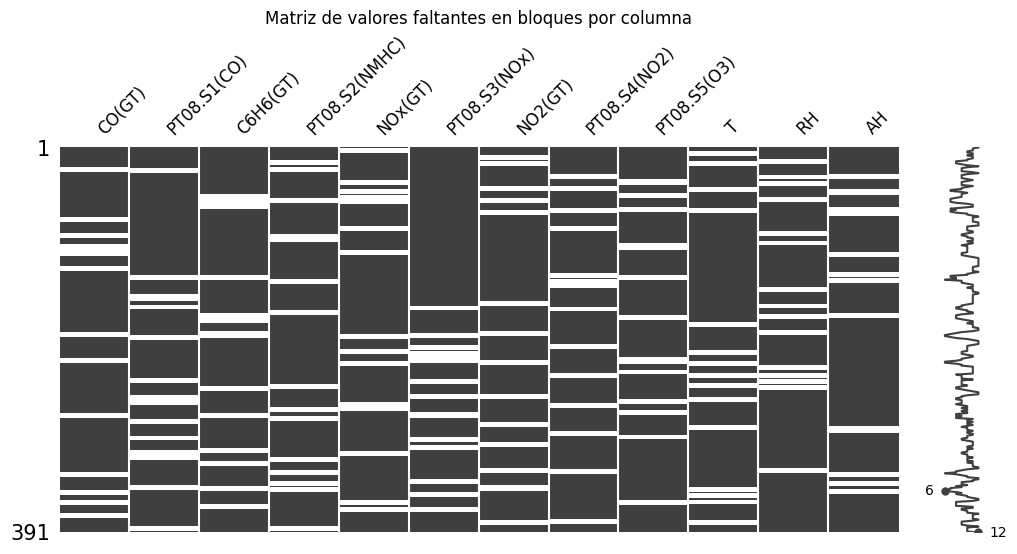

In [39]:
msno.matrix(df_missing, figsize=(12, 5), fontsize=12)
plt.title("Matriz de valores faltantes en bloques por columna")
plt.show()


### Celda 5 – Graficar series temporales marcando los valores faltantes

En esta celda dibujo, para cada variable:

- La serie original diaria (`df_original`) como una línea azul.
- Los puntos donde se introdujeron `NaN` (`df_missing`) como puntos rojos sobre la misma serie.

La idea es ver claramente:

- Cómo se ve la forma original de la serie.
- En qué días exactamente “desaparecieron” los datos por la simulación de fallos.

Esto ayuda a entender el impacto visual y temporal de los datos faltantes en cada variable.


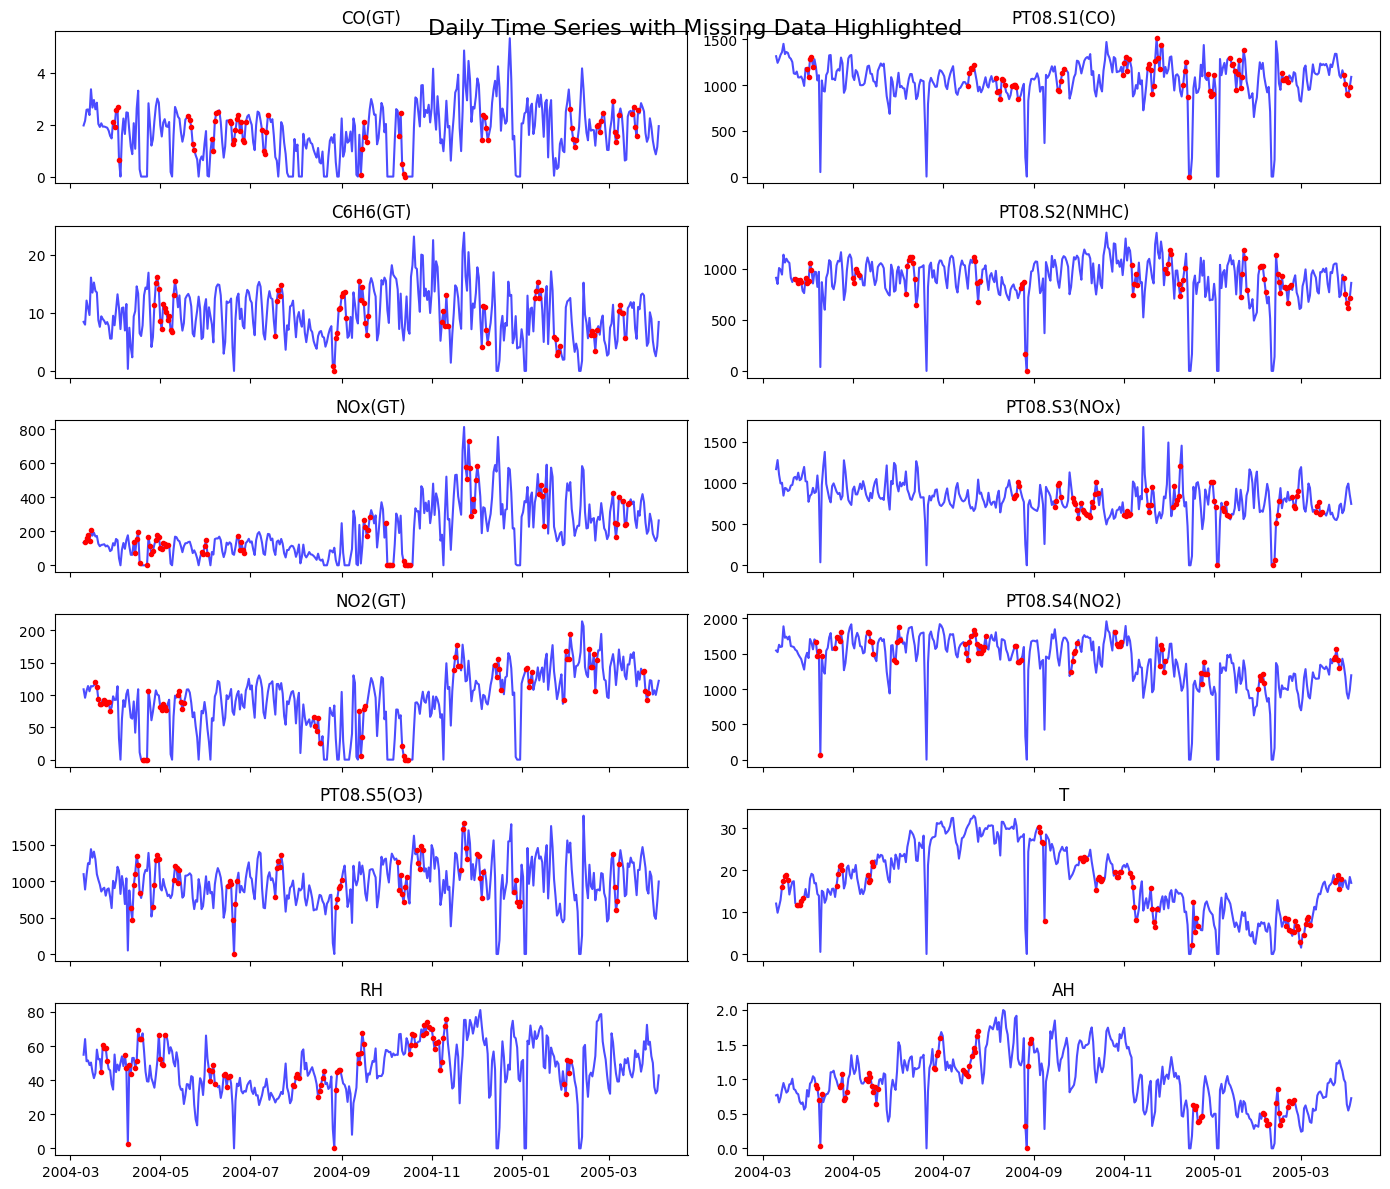

In [40]:
cols = df_missing.columns
n_cols = 2
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 2 * n_rows), sharex=True)
axes = axes.reshape(n_rows, n_cols)

for i, col in enumerate(cols):
    ax = axes[i // n_cols, i % n_cols]
    ax.plot(df_missing.index, df_original[col], color='blue', alpha=0.7)
    ax.plot(df_missing.index[df_missing[col].isna()],
            df_original[col][df_missing[col].isna()],
            'r.', markersize=6)
    ax.set_title(col)

for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.suptitle("Daily Time Series with Missing Data Highlighted", fontsize=16)
plt.show()


### Celda 6 – Instalar la librería PyPOTS (SAITS)

En esta celda instalo la librería `pypots`, que contiene el modelo SAITS para imputación de series temporales.

- Solo es necesario ejecutarla una vez en el entorno.
- Sin esta instalación no podría importar ni usar el modelo SAITS.

Esta celda prepara el entorno para poder aplicar imputación basada en Transformers.


In [41]:
!pip install pypots==0.11


In [42]:
# Verificar si PyPOTS está instalado
import importlib

package_name = "pypots"
spec = importlib.util.find_spec(package_name)

if spec is None:
    print("❌ PyPOTS NO está instalado.")
else:
    print("✅ PyPOTS está instalado.")


✅ PyPOTS está instalado.


### Celda 7 – Preparar los datos para entrenar SAITS

En esta celda transformo el dataset con missing (`df_missing`) al formato que necesita SAITS:

1. Fijo la longitud de la ventana temporal (`seq_len = 7`), es decir, uso 7 días seguidos como secuencia.
2. Cuento cuántas variables hay (`n_features`).
3. Convierto el DataFrame a un arreglo `numpy` llamado `data`.
4. Genero ventanas deslizantes de 7 días para cubrir toda la serie:
   - Cada muestra `X[i]` contiene 7 días consecutivos.
5. Ajusto el arreglo para que el número de filas coincida con el número de días originales:
   - Repito y completo filas para tener la misma longitud temporal.
6. Normalizo todas las variables con `MinMaxScaler`:
   - Esto lleva cada columna a un rango entre 0 y 1.
   - La normalización ayuda a que el modelo entrene mejor.

Al final, `X_scaled` contiene las secuencias normalizadas que usaré como entrada de SAITS.


In [43]:
from pypots.imputation import SAITS
from sklearn.preprocessing import MinMaxScaler

seq_len = 7
n_features = len(df_missing.columns)

data = df_missing.to_numpy(dtype=np.float32)

n_samples = len(data) - seq_len + 1
X = np.array([data[i:i + seq_len] for i in range(n_samples)])

repeat_factor = data.shape[0] // X.shape[0]
extra_rows = data.shape[0] % X.shape[0]

expanded_arr = np.repeat(X, repeat_factor, axis=0)
expanded_arr = np.vstack([expanded_arr, X[:extra_rows]])

expanded_arr[-extra_rows:, 0, :] = data[-extra_rows:]

scaler = MinMaxScaler()
X_reshaped = expanded_arr.reshape(-1, expanded_arr.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(expanded_arr.shape)


### Celda 8 – Definir, entrenar y aplicar el modelo SAITS

En esta celda:

1. Creo un modelo SAITS indicando:
   - Número de pasos temporales (`n_steps = seq_len`).
   - Número de variables (`n_features`).
   - Número de capas, tamaño de las representaciones internas y demás parámetros de la red.
2. Armo un diccionario `dataset = {"X": X_scaled}` que es el formato que espera la librería.
3. Llamo a `saits.fit(dataset)` para entrenar el modelo sobre las secuencias con datos faltantes.
4. Uso `saits.impute(dataset)` para que el modelo complete (impute) los valores que faltan.

El resultado `imputation` es un arreglo con los mismos datos, pero con los huecos rellenados por el modelo.


In [44]:
saits = SAITS(
    n_steps=seq_len,
    n_features=n_features,
    n_layers=2,
    d_model=256,
    d_ffn=128,
    n_heads=4,
    d_k=64,
    d_v=64,
    dropout=0.1,
    epochs=100
)

dataset = {"X": X_scaled}
saits.fit(dataset)
imputation = saits.impute(dataset)


2025-11-19 02:01:54 [INFO]: No given device, using default device: cpu
2025-11-19 02:01:54 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-11-19 02:01:54 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,335,716
2025-11-19 02:01:55 [INFO]: Epoch 001 - training loss (MSE): 0.3109
2025-11-19 02:01:55 [INFO]: Epoch 002 - training loss (MSE): 0.1371
2025-11-19 02:01:56 [INFO]: Epoch 003 - training loss (MSE): 0.1093
2025-11-19 02:01:56 [INFO]: Epoch 004 - training loss (MSE): 0.0918
2025-11-19 02:01:56 [INFO]: Epoch 005 - training loss (MSE): 0.0801
2025-11-19 02:01:57 [INFO]: Epoch 006 - training loss (MSE): 0.0726
2025-11-19 02:01:57 [INFO]: Epoch 007 - training loss (MSE): 0.0668
2025-11-19 02:01:58 [INFO]: Epoch 008 - training loss (MSE): 0.0614
2025-11-19 02:01:58 [INFO]: Epoch 009 - training loss (MSE): 0.0573
2025-11-19 02:01:58 [INFO]: Epoch 010 - training loss (MSE): 0.0612
2025-11-19 02:01

### Celda 9 – Desnormalizar y reconstruir el DataFrame imputado

En esta celda convierto la imputación de SAITS de vuelta a un formato entendible:

1. Reorganizo el arreglo `imputation` para poder aplicar el inverso del escalado (`inverse_transform`).
2. Deshago la normalización para volver a los valores originales (las unidades reales de cada variable).
3. Me quedo con la primera posición de cada ventana imputada, que corresponde al tiempo original que quiero reconstruir.
4. Construyo un nuevo DataFrame `data_imputed`:
   - Con las mismas columnas que el original.
   - Con el mismo índice de fechas.
   - Con los valores imputados donde antes había `NaN`.

Al final de esta celda tengo una versión completa de la serie, sin huecos, imputada por SAITS.


In [45]:
imputation_reshaped = imputation.reshape(-1, imputation.shape[-1])
imputation_denorm = scaler.inverse_transform(imputation_reshaped)
imputation_denorm = imputation_denorm.reshape(imputation.shape)

imputed_values = imputation_denorm[:, 0, :]

data_imputed = pd.DataFrame(
    imputed_values,
    columns=df_original.columns,
    index=df_original.index[:imputed_values.shape[0]]
)


### Celda 10 – Comparar visualmente serie original vs serie imputada

En esta celda genero un conjunto de gráficos para todas las variables:

- Línea azul: valores originales diarios (`df_original`).
- Línea naranja punteada: valores imputados (`data_imputed`).

La idea es:

- Ver qué tan cerca están las curvas imputadas de las originales.
- Detectar si el modelo respeta la forma general de cada serie.
- Notar si en zonas con muchos huecos imputados la serie sigue siendo razonable.

Esta comparación visual es clave para evaluar la calidad de la imputación antes de pasar al modelado con redes (LSTM o Transformer).


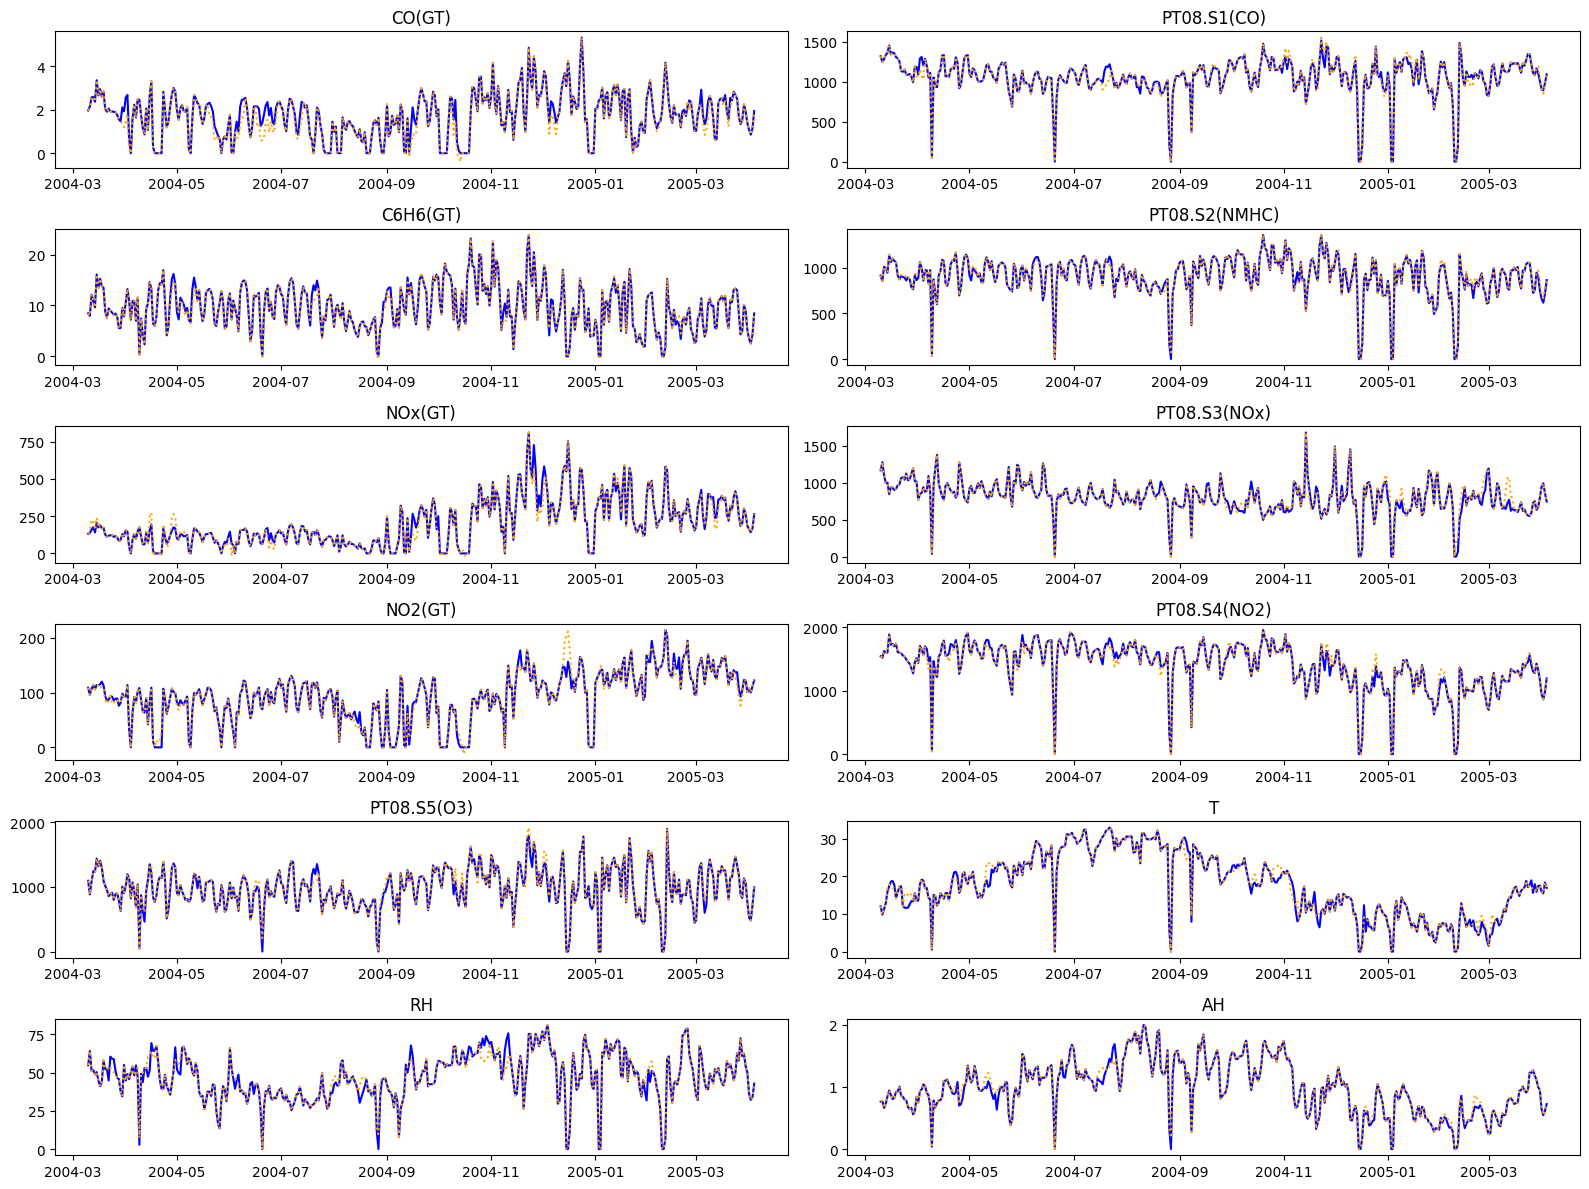

In [46]:
fig, axes = plt.subplots(
    int(np.ceil(len(df_original.columns) / 2)), 2,
    figsize=(16, 2 * int(np.ceil(len(df_original.columns) / 2)))
)

for ax, col in zip(axes.flat, df_original.columns):
    ax.plot(df_original.index, df_original[col], label="Original", color='blue')
    ax.plot(df_original.index, data_imputed[col], ':', label="Imputed", color='orange')
    ax.set_title(col)

plt.tight_layout()
plt.show()


### Celda 11 – Preparar los datos para el modelo Transformer (univariado)

En esta celda convierto la serie imputada de CO(GT) en secuencias para el modelo.  
Uso una ventana de 7 días (seq_len = 7), donde cada secuencia contiene 7 valores consecutivos, y el modelo debe predecir el valor del día siguiente.  
Aquí genero dos arreglos:

- **X**: las secuencias de entrada (7 días)
- **y**: el valor objetivo (día 8)

Además, agrego una dimensión extra para que el Transformer pueda interpretar las entradas como una serie con 1 característica.  
Al final, dejo los datos listos para el entrenamiento del modelo.


In [47]:
# ----------------------------------------
# 📌 PREPARAR LOS DATOS (TRANSFORMER UNIVARIADO)
# ----------------------------------------
seq_len = 7  # Usamos 7 días como ventana

# Tomamos la serie imputada
series = data_imputed['CO(GT)'].to_numpy(dtype=np.float32)

# Generar secuencias y etiquetas
X = []
y = []

for i in range(len(series) - seq_len):
    X.append(series[i:i + seq_len])
    y.append(series[i + seq_len])

X = np.array(X)
y = np.array(y)

# Añadir dimensión de características (1 variable: CO)
X = X[..., np.newaxis]  # (samples, seq_len, 1)

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Shape X: (384, 7, 1)
Shape y: (384,)


### Celda 12 – Definir el modelo Transformer univariado

En esta celda creo el modelo Transformer que se utilizará para predecir el CO(GT).  
El modelo incluye:

- Una capa lineal para proyectar cada valor a un vector interno (d_model).
- Dos capas TransformerEncoder que procesan la secuencia completa.
- Una capa final que devuelve la predicción del valor siguiente.

Este modelo es sencillo y adecuado para un ejercicio low-code.  
Queda listo para entrenarse en la celda siguiente.


In [48]:
# ----------------------------------------
# 📌 DEFINIR EL TRANSFORMER (UNIVARIADO)
# ----------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class SimpleTransformer(nn.Module):
    def __init__(self, seq_len, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)                 # (batch, seq_len, d_model)
        x = x.permute(1, 0, 2)                 # (seq_len, batch, d_model)
        x = self.transformer(x)                # Procesa la secuencia completa
        x = x[-1]                              # Tomamos el último paso temporal
        x = self.output(x).squeeze(1)          # Predicción final
        return x

model = SimpleTransformer(seq_len=seq_len)


c:\Users\asus\Documents\Redes Neuronales\Modelado-de-datos-temporales-con-redes-neuronales\.venv\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### Celda 13 – Entrenar el modelo Transformer univariado

Aquí entreno el modelo usando 50 épocas.  
Primero creo un DataLoader para manejar los datos en lotes (batch_size = 16).  
Luego defino la función de pérdida MSE y el optimizador Adam.

Durante cada época:

1. El modelo hace predicciones.
2. Se calcula la pérdida.
3. Se ajustan los pesos del modelo para mejorar la predicción.

Al final, se imprime la pérdida por época para ver cómo va aprendiendo el modelo.


In [49]:
# ----------------------------------------
# 📌 ENTRENAR EL TRANSFORMER UNIVARIADO
# ----------------------------------------
batch_size = 16
dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 50

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        pred = model(batch_X)
        loss = loss_fn(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss / len(loader):.4f}")


Epoch 1/50, Loss: 1.1178
Epoch 2/50, Loss: 0.6861
Epoch 3/50, Loss: 0.5972
Epoch 4/50, Loss: 0.5893
Epoch 5/50, Loss: 0.5847
Epoch 6/50, Loss: 0.5912
Epoch 7/50, Loss: 0.5915
Epoch 8/50, Loss: 0.5814
Epoch 9/50, Loss: 0.6037
Epoch 10/50, Loss: 0.5696
Epoch 11/50, Loss: 0.5691
Epoch 12/50, Loss: 0.6249
Epoch 13/50, Loss: 0.5586
Epoch 14/50, Loss: 0.5575
Epoch 15/50, Loss: 0.5781
Epoch 16/50, Loss: 0.5640
Epoch 17/50, Loss: 0.5452
Epoch 18/50, Loss: 0.5521
Epoch 19/50, Loss: 0.5463
Epoch 20/50, Loss: 0.5503
Epoch 21/50, Loss: 0.5509
Epoch 22/50, Loss: 0.5484
Epoch 23/50, Loss: 0.5675
Epoch 24/50, Loss: 0.5622
Epoch 25/50, Loss: 0.5466
Epoch 26/50, Loss: 0.5391
Epoch 27/50, Loss: 0.5514
Epoch 28/50, Loss: 0.5562
Epoch 29/50, Loss: 0.5386
Epoch 30/50, Loss: 0.5452
Epoch 31/50, Loss: 0.5526
Epoch 32/50, Loss: 0.5470
Epoch 33/50, Loss: 0.5664
Epoch 34/50, Loss: 0.5441
Epoch 35/50, Loss: 0.5241
Epoch 36/50, Loss: 0.5332
Epoch 37/50, Loss: 0.5323
Epoch 38/50, Loss: 0.5477
Epoch 39/50, Loss: 0.

### Celda 14 – Evaluar y graficar las predicciones del modelo univariado

En esta celda uso el modelo entrenado para predecir los valores de CO(GT) en todo el conjunto de datos.  
Luego grafico:

- La serie real (línea azul)
- La predicción del modelo (línea naranja punteada)

El objetivo es observar visualmente qué tan bien el modelo sigue la forma de la serie.  
Este gráfico permite evaluar la calidad del ajuste antes de pasar al modelo multivariado.


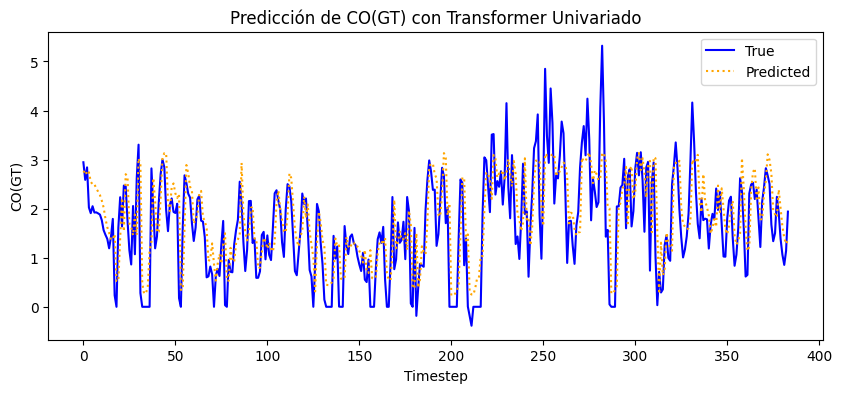

In [50]:
# ----------------------------------------
# 📌 EVALUAR Y GRAFICAR PREDICCIONES (UNIVARIADO)
# ----------------------------------------
model.eval()
with torch.no_grad():
    y_pred = model(torch.from_numpy(X)).numpy()

plt.figure(figsize=(10,4))
plt.plot(y, label="True", color='blue')
plt.plot(y_pred, label="Predicted", linestyle=':', color='orange')
plt.legend()
plt.title("Predicción de CO(GT) con Transformer Univariado")
plt.xlabel("Timestep")
plt.ylabel("CO(GT)")
plt.show()


Interpretación:
El modelo univariado hace un trabajo decente captando la forma general del CO(GT), pero hasta ahí. La pérdida se queda rondando el mismo valor y eso ya adelanta que el modelo no logra mejorar mucho más.
Cuando se observa la predicción, se nota que sigue la tendencia global, pero no alcanza los picos ni reacciona rápido cuando la serie cambia bruscamente. Básicamente, el modelo “suaviza” la señal y se queda corto en los detalles finos.
Esto es lo que cabía esperar: está entrenado solo con una variable, tiene una arquitectura pequeña y poca capacidad para anticipar variaciones repentinas. En resumen, funciona para ver el comportamiento general, pero no tiene la precisión suficiente para capturar movimientos rápidos del CO(GT).

### Celda 15 – Preparar los datos para el modelo Transformer multivariado

En esta celda preparo el dataset imputado para usarlo en un modelo Transformer que utilizará **todas las variables** como entrada, pero solo predecirá **CO(GT)**.  

Lo que hago es:

1. Tomo el DataFrame imputado (`data_imputed`) y lo convierto en un arreglo.
2. Uso una ventana temporal de 7 días (`seq_len = 7`).
3. Para cada ventana de 7 días, guardo:
   - **X**: los 7 días completos con todas las columnas.
   - **y**: el valor de `CO(GT)` del día siguiente.
4. Al final obtengo:
   - `X` con forma (muestras, 7, variables).
   - `y` con las etiquetas que el modelo debe aprender a predecir.

Con esta celda dejo todo listo para separar train/test y entrenar el Transformer multivariado.


In [51]:
# ----------------------------------------
# 📌 PREPARAR LOS DATOS (TRANSFORMER MULTIVARIADO)
# ----------------------------------------
import numpy as np

seq_len = 7
data_arr = data_imputed.to_numpy(dtype=np.float32)

X = []
y = []

co_idx = data_imputed.columns.get_loc('CO(GT)')

for i in range(len(data_arr) - seq_len):
    X.append(data_arr[i:i + seq_len])                # 7 días de TODAS las variables
    y.append(data_arr[i + seq_len][co_idx])          # CO(GT) del día siguiente

X = np.array(X)
y = np.array(y)

print("Shape X:", X.shape)   # (samples, seq_len, n_features)
print("Shape y:", y.shape)   # (samples,)


Shape X: (384, 7, 12)
Shape y: (384,)


### Celda 16 – Separar train/test y crear el DataLoader

En esta celda divido los datos en entrenamiento y prueba:

- 80% para entrenamiento.
- 20% para test (la parte final del tiempo).

Luego creo un `DataLoader`, que es la forma en la que PyTorch maneja los datos en pequeños lotes durante el entrenamiento.  
Esto permite entrenar más rápido y con mayor estabilidad.

Al final de la celda ya tengo:

- `X_train`, `y_train` para entrenar.
- `X_test`, `y_test` para evaluar después.
- `train_loader` listo para usar en el ciclo de entrenamiento.


In [52]:
# ----------------------------------------
# 📌 SEPARAR TRAIN / TEST Y CREAR DATALOADER
# ----------------------------------------
from torch.utils.data import DataLoader, TensorDataset
import torch

split_idx = int(0.8 * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

batch_size = 16

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Train samples: 307
Test samples: 77


### Celda 17 – Definir el modelo Transformer multivariado

En esta celda creo la arquitectura del modelo Transformer que hará la predicción multivariada.

El modelo hace lo siguiente:

1. **Input projection**: convierte cada fila de datos (todas las variables) en un vector interno.
2. **Encoder Transformer**: procesa las secuencias usando varias capas de atención.
3. **Salida**: toma el último paso temporal de la secuencia y lo pasa por una capa final para predecir `CO(GT)`.

Este modelo es más poderoso que el univariado porque tiene acceso a todas las variables ambientales y a los sensores químicos del dataset.  
Con esto ya tengo un Transformer listo para entrenar.


In [53]:
# ----------------------------------------
# 📌 DEFINIR EL TRANSFORMER MULTIVARIADO
# ----------------------------------------
import torch.nn as nn

class ForecastTransformer(nn.Module):
    def __init__(self, n_features, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        x = self.input_proj(x)           # (batch, seq_len, d_model)
        x = x.permute(1, 0, 2)          # (seq_len, batch, d_model)
        x = self.transformer(x)         # procesa la secuencia
        x = x[-1]                       # último paso temporal
        x = self.output(x).squeeze(1)   # (batch,)
        return x

n_features = X.shape[2]
model_mv = ForecastTransformer(n_features=n_features)


### Celda 18 – Entrenar el Transformer multivariado

Aquí entreno el modelo usando solo los datos de entrenamiento.

Lo que ocurre en esta celda es:

1. Defino la función de pérdida (MSE).
2. Selecciono el optimizador (Adam).
3. Entreno el modelo durante 50 épocas.
4. En cada época:
   - El modelo predice.
   - Comparo contra los valores reales.
   - Calcula el error.
   - Ajusta los pesos para mejorar.

Al final de esta celda el Transformer ya está entrenado y listo para generar predicciones tanto en train como en test.


In [54]:
# ----------------------------------------
# 📌 ENTRENAR EL TRANSFORMER MULTIVARIADO
# ----------------------------------------
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_mv.parameters(), lr=1e-3)

n_epochs = 50

for epoch in range(n_epochs):
    model_mv.train()
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        pred = model_mv(batch_X)
        loss = loss_fn(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/50, Loss: 1.3327
Epoch 2/50, Loss: 1.0699
Epoch 3/50, Loss: 0.9507
Epoch 4/50, Loss: 0.9313
Epoch 5/50, Loss: 0.8754
Epoch 6/50, Loss: 0.8998
Epoch 7/50, Loss: 0.7474
Epoch 8/50, Loss: 0.8275
Epoch 9/50, Loss: 0.7544
Epoch 10/50, Loss: 0.9124
Epoch 11/50, Loss: 0.7861
Epoch 12/50, Loss: 0.7807
Epoch 13/50, Loss: 0.7409
Epoch 14/50, Loss: 0.6915
Epoch 15/50, Loss: 0.7747
Epoch 16/50, Loss: 0.7188
Epoch 17/50, Loss: 0.6813
Epoch 18/50, Loss: 0.6811
Epoch 19/50, Loss: 0.8596
Epoch 20/50, Loss: 0.7168
Epoch 21/50, Loss: 0.8072
Epoch 22/50, Loss: 0.6664
Epoch 23/50, Loss: 0.6933
Epoch 24/50, Loss: 0.6420
Epoch 25/50, Loss: 0.6283
Epoch 26/50, Loss: 0.6494
Epoch 27/50, Loss: 0.6581
Epoch 28/50, Loss: 0.8441
Epoch 29/50, Loss: 0.7826
Epoch 30/50, Loss: 0.7438
Epoch 31/50, Loss: 0.6641
Epoch 32/50, Loss: 0.6626
Epoch 33/50, Loss: 0.7234
Epoch 34/50, Loss: 0.6398
Epoch 35/50, Loss: 0.6070
Epoch 36/50, Loss: 0.5888
Epoch 37/50, Loss: 0.6372
Epoch 38/50, Loss: 0.6206
Epoch 39/50, Loss: 0.

### Celda 19 – Predicciones y gráfico general (train + test)

En esta celda genero las predicciones del modelo para todo el dataset:

- `y_pred_train`: predicciones en el conjunto de entrenamiento.
- `y_pred_test`: predicciones en el conjunto de prueba (futuro).

Luego dibujo un solo gráfico donde comparo:

- La serie real completa de CO(GT).
- Las predicciones en train.
- Las predicciones en test.
- Una línea vertical que marca la separación entre ambas.

Este gráfico sirve para evaluar cómo se ajusta el modelo tanto en los datos conocidos como en el periodo futuro.


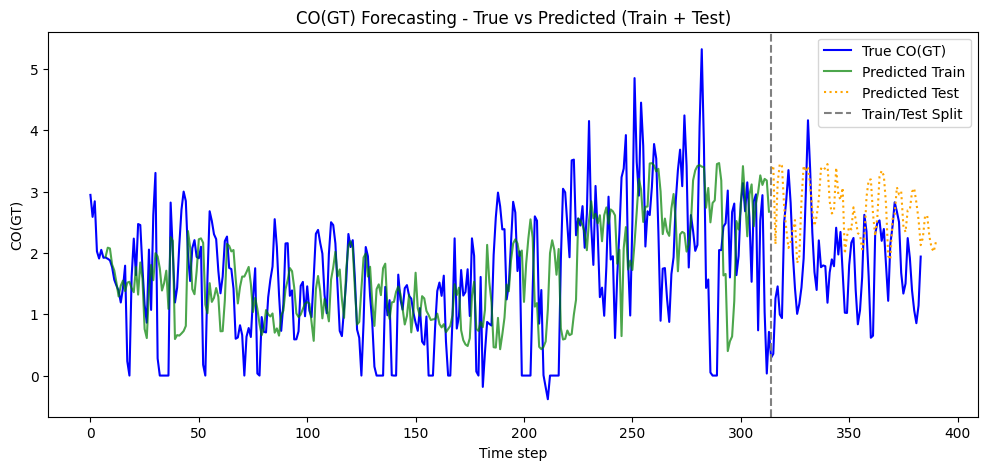

In [55]:
# ----------------------------------------
# 📌 PREDICCIONES Y GRÁFICO GENERAL (TRAIN + TEST)
# ----------------------------------------
model_mv.eval()
with torch.no_grad():
    y_pred_train = model_mv(torch.from_numpy(X_train)).numpy()
    y_pred_test = model_mv(torch.from_numpy(X_test)).numpy()

plt.figure(figsize=(12, 5))
plt.plot(range(len(y)), y, label='True CO(GT)', color='blue')

# Predicciones train
plt.plot(range(seq_len, seq_len + len(y_pred_train)),
         y_pred_train, label='Predicted Train', color='green', alpha=0.7)

# Predicciones test
plt.plot(range(seq_len + len(y_pred_train),
               seq_len + len(y_pred_train) + len(y_pred_test)),
         y_pred_test, label='Predicted Test', color='orange', linestyle=':')

# Línea de separación train/test
plt.axvline(seq_len + len(y_pred_train), color='gray', linestyle='--', label='Train/Test Split')

plt.legend()
plt.title("CO(GT) Forecasting - True vs Predicted (Train + Test)")
plt.xlabel("Time step")
plt.ylabel("CO(GT)")
plt.show()


### Celda 20 – Gráfico detallado del conjunto de test

Esta celda hace un zoom solamente en el conjunto de test.

Dibujo dos curvas:

- Los valores reales de CO(GT) en test.
- Las predicciones del Transformer.

Este gráfico permite evaluar si el modelo es capaz de seguir la forma, tendencia y variaciones del CO(GT) en el periodo futuro, que es la parte más importante de un modelo de forecasting.


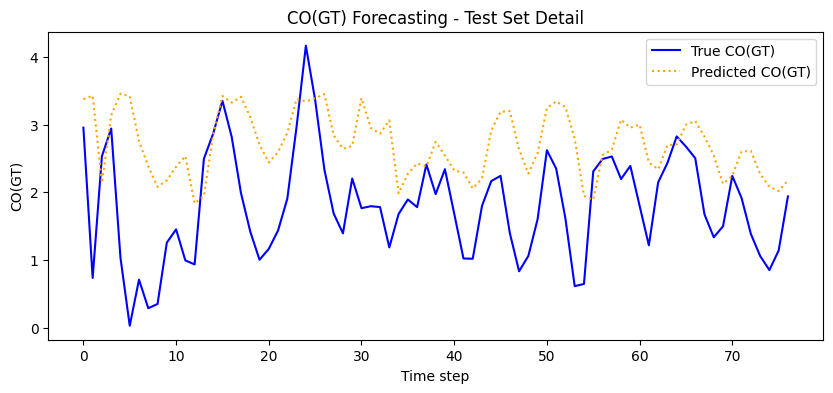

In [56]:
# ----------------------------------------
# 📌 PLOT DETALLE DEL TEST
# ----------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='True CO(GT)', color='blue')
plt.plot(y_pred_test, label='Predicted CO(GT)', color='orange', linestyle=':')
plt.legend()
plt.title("CO(GT) Forecasting - Test Set Detail")
plt.xlabel("Time step")
plt.ylabel("CO(GT)")
plt.show()


Interpretación:
Al pasar al modelo multivariado, sí hay una mejora, aunque no es gigantesca. El entrenamiento es más estable y la pérdida baja un poco más que en el univariado, lo cual muestra que el modelo aprovecha tener más variables.
En el gráfico completo se ve que en la parte de entrenamiento las predicciones encajan mejor con la serie real. En el test, el modelo logra mantener la forma general del CO(GT), pero sigue teniendo el mismo problema de antes: suaviza los picos y no llega a los valores más extremos.
En el zoom del test se nota claramente que entiende la dinámica, pero no es capaz de seguirle el ritmo a los cambios bruscos. Es un modelo que “entiende la historia”, pero aún le falta potencia para afinar los detalles.
En resumen, el multivariado es mejor que el univariado, pero todavía no captura toda la variabilidad del CO(GT). Aun así, el resultado es bueno para un ejercicio low-code.

## Comparación final

Conclusión general:
El univariado se queda corto porque solo ve una parte del problema. Aprende la tendencia, pero suaviza demasiado la señal y falla en los puntos donde el CO(GT) cambia rápido.
El multivariado mejora, porque tiene más información para trabajar, y eso se refleja en una predicción más coherente y con menor error. Sin embargo, tampoco logra capturar los picos importantes ni los cambios repentinos.
En conjunto, los resultados tienen sentido para el tipo de modelo usado y para el objetivo low-code de la actividad. Se completa bien el flujo completo: datos → imputación → modelo → predicción, y se obtiene una idea clara de cómo responden los transformadores en series temporales reales.